In [ ]:
import re
import math
import html

# URLs: http(s)://... o www....
URL_RE = re.compile(r'https?://\S+|www\.\S+')

# Menciones: @usuario (hasta el próximo espacio)
MENTION_RE = re.compile(r'@\S+')


HTML_TAG_RE = re.compile(r'<[^>]+>')

def strip_html(text: str) -> str:
    text = str(text)
    return HTML_TAG_RE.sub(" ", text)
# Emojis Unicode (rangos más comunes)
EMOJI_RE = re.compile(
    "["
    u"\U0001F600-\U0001F64F"  # emoticonos
    u"\U0001F300-\U0001F5FF"  # símbolos y pictos
    u"\U0001F680-\U0001F6FF"  # transporte
    u"\U0001F1E0-\U0001F1FF"  # banderas
    u"\U00002700-\U000027BF"  # dingbats
    u"\U0001F900-\U0001F9FF"  # más emojis
    "]+",
    flags=re.UNICODE,
)

# Emoticonos ASCII tipo :) :( :D <3
ASCII_EMOTICON_RE = re.compile(
    r'((:|;|=|8|x|X)[\-o\']?(\)|\(|D|p|P|3|/|\\))|<3'
)

# RT al inicio típico de retweets
RT_RE = re.compile(r'^\s*rt\b', flags=re.IGNORECASE)

def clean_tweet(text):
    from html import unescape
    # Manejo NaN / None para que no se conviertan en "nan"
    if text is None:
        return ""
    # Si vienen floats tipo NaN de pandas
    if isinstance(text, float) and math.isnan(text):
        return ""

    # Asegurar string
    text = str(text)

    text = strip_html(text)

    # Decodificar entidades HTML (&amp;, &lt;, etc.)
    text = unescape(text)

    # Eliminar URLs
    text = URL_RE.sub(" ", text)

    # Eliminar @usuario
    text = MENTION_RE.sub(" ", text)

    # Eliminar emojis unicode
    text = EMOJI_RE.sub(" ", text)

    # Eliminar emoticonos ASCII
    text = ASCII_EMOTICON_RE.sub(" ", text)

    # Quitar el "RT" inicial típico de retweets
    text = RT_RE.sub(" ", text)

    # Quitar # pero dejar la palabra
    text = re.sub(r'#(\w+)', r'\1', text)

    # Pasar a minúsculas
    text = text.lower()

    # Quitar espacios repetidos
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

df_fire_train = pd.read_csv(
    'event_type/fire_train.tsv',
    sep='\t',          # separador = tab
    encoding='utf-8'
)
df_flood_train = pd.read_csv(
    'event_type/flood_train.tsv',
    sep='\t',          # separador = tab
    encoding='utf-8'
)

df_hurricane_train = pd.read_csv(
    'event_type/hurricane_train.tsv',
    sep='\t',          # separador = tab
    encoding='utf-8'
)

df_earthquake_train = pd.read_csv(
    'event_type/earthquake_train.tsv',
    sep='\t',          # separador = tab
    encoding='utf-8'
)

df_fire_test = pd.read_csv(
    'event_type/fire_test.tsv',
    sep='\t',          # separador = tab
    encoding='utf-8'
)

df_flood_test = pd.read_csv(
    'event_type/flood_test.tsv',
    sep='\t',          # separador = tab
    encoding='utf-8'
)

df_hurricane_test = pd.read_csv(
    'event_type/hurricane_test.tsv',
    sep='\t',          # separador = tab
    encoding='utf-8'
)

df_earthquake_test = pd.read_csv(
    'event_type/earthquake_test.tsv',
    sep='\t',          # separador = tab
    encoding='utf-8'
)

df_fire_dev = pd.read_csv(
    'event_type/fire_dev.tsv',
    sep='\t',          # separador = tab
    encoding='utf-8'
)

df_flood_dev = pd.read_csv(
    'event_type/flood_dev.tsv',
    sep='\t',          # separador = tab
    encoding='utf-8'
)

df_earthquake_dev = pd.read_csv(
    'event_type/earthquake_dev.tsv',
    sep='\t',          # separador = tab
    encoding='utf-8'
)
df_hurricane_dev = pd.read_csv(
    'event_type/hurricane_dev.tsv',
    sep='\t',          # separador = tab
    encoding='utf-8'
)

# TRAIN
df_fire_train["disaster_type"]       = "fire"
df_flood_train["disaster_type"]      = "flood"
df_hurricane_train["disaster_type"]  = "hurricane"
df_earthquake_train["disaster_type"] = "earthquake"

# DEV
df_fire_dev["disaster_type"]       = "fire"
df_flood_dev["disaster_type"]      = "flood"
df_hurricane_dev["disaster_type"]  = "hurricane"
df_earthquake_dev["disaster_type"] = "earthquake"

# TEST
df_fire_test["disaster_type"]       = "fire"
df_flood_test["disaster_type"]      = "flood"
df_hurricane_test["disaster_type"]  = "hurricane"
df_earthquake_test["disaster_type"] = "earthquake"


# Lista de todos los dataframes
all_train = [
    df_fire_train, df_flood_train, df_hurricane_train, df_earthquake_train,
]

all_dev = [
        df_fire_dev,   df_flood_dev,   df_hurricane_dev,   df_earthquake_dev,
]

all_test =[
        df_fire_test,  df_flood_test,  df_hurricane_test,  df_earthquake_test,
]

# Clean tweets
for df in all_train:
    df["tweet_text"] = df["tweet_text"].astype(str).apply(clean_tweet)

for df in all_dev:
    df["tweet_text"] = df["tweet_text"].astype(str).apply(clean_tweet)

for df in all_test:
    df["tweet_text"] = df["tweet_text"].astype(str).apply(clean_tweet)


#concat tweets by objective
df_all_train = pd.concat(
    [
        df_fire_train,
        df_flood_train,
        df_hurricane_train,
        df_earthquake_train,
    ],
    ignore_index=True
    )

df_all_dev = pd.concat(
    [
        df_fire_dev,
        df_flood_dev,
        df_hurricane_dev,
        df_earthquake_dev,
    ],
    ignore_index=True
    )

df_all_test = pd.concat(
    [
        df_fire_test,
        df_flood_test,
        df_hurricane_test,
        df_earthquake_test,
    ],
    ignore_index=True
    )

#vectorize
vectorizer = TfidfVectorizer(
    preprocessor=clean_tweet,   # tu función
    strip_accents='ascii',
    stop_words='english',
)

vectorizer.fit(df_all_train['tweet_text'])

X_all_train = vectorizer.transform(df_all_train['tweet_text'])




Entrenando KMeans con k = 2...
Entrenando KMeans con k = 3...
Entrenando KMeans con k = 4...
Entrenando KMeans con k = 5...
Entrenando KMeans con k = 6...
Entrenando KMeans con k = 7...
Entrenando KMeans con k = 8...
Entrenando KMeans con k = 9...
Entrenando KMeans con k = 10...
Entrenando KMeans con k = 11...
Entrenando KMeans con k = 12...
Entrenando KMeans con k = 13...
Entrenando KMeans con k = 14...
Entrenando KMeans con k = 15...
Entrenando KMeans con k = 16...
Entrenando KMeans con k = 17...
Entrenando KMeans con k = 18...
Entrenando KMeans con k = 19...
Entrenando KMeans con k = 20...
Entrenando KMeans con k = 21...
Entrenando KMeans con k = 22...
Entrenando KMeans con k = 23...
Entrenando KMeans con k = 24...
Entrenando KMeans con k = 25...
Entrenando KMeans con k = 26...
Entrenando KMeans con k = 27...
Entrenando KMeans con k = 28...
Entrenando KMeans con k = 29...
Entrenando KMeans con k = 30...
Entrenando KMeans con k = 31...


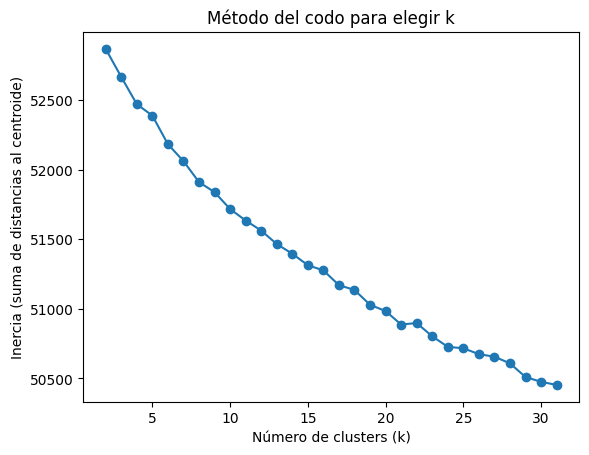

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Rango de k a probar (ajusta según tamaño de tu dataset)
K_values = range(2, 32)   # k = 2,3,...,20

inertias = []

for k in K_values:
    print(f"Entrenando KMeans con k = {k}...")
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    kmeans.fit(X_all_train)
    inertias.append(kmeans.inertia_)

# Graficar k vs inercia
plt.figure()
plt.plot(list(K_values), inertias, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia (suma de distancias al centroide)")
plt.title("Método del codo para elegir k")
plt.show()


In [ ]:
from sklearn.cluster import KMeans

k = 23
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_ids = kmeans.fit_predict(X_all_train)  # vector de tamaño N con valores 0..9
df_all_train['cluster'] = cluster_ids



In [ ]:
pd.set_option('display.max_rows', 100) 
pd.set_option('display.max_colwidth', 15) 
df_all_train['cluster'].value_counts()


cluster
1     15570
22     3348
6      3203
18     3045
2      2961
7      2883
12     2386
9      2146
4      1876
15     1698
10     1598
20     1483
11     1454
0      1258
17     1195
13     1189
14     1093
16      966
21      961
8       942
5       937
3       671
19      659
Name: count, dtype: int64

In [ ]:
df_cluster1 = df_all_train[df_all_train['cluster'] == 0].reset_index(drop=True)
df_cluster1.loc[701:800, ['tweet_text', 'class_label',
'disaster_type','cluster']]


In [ ]:
tabla = pd.crosstab(df_all_train['cluster'], df_all_train['disaster_type'])
tabla

disaster_type  earthquake  fire  flood  hurricane
cluster                                          
0                       0     0      0       1258
1                    1283  1541   3376       9370
2                     281   351    414       1915
3                     668     2      0          1
4                       6     5      5       1860
5                      17   137      3        780
6                       0  3180      4         19
7                       1     0      0       2882
8                     940     0      2          0
9                      78    71    446       1551
10                    235   754     70        539
11                   1348     0      2        104
12                      0     0      0       2386
13                    243   100     99        747
14                      1     4     12       1076
15                      0     2      0       1696
16                      2     3      3        958
17                   1095     0      0        100
18                      0     0      0       3045
19                     52   162     43        402
20                      0  1480      0          3
21                      0     0      0        961
22                      0     0   3336         12

In [ ]:
df_cluster0 = df_all_train[df_all_train['cluster'] == 0].reset_index(drop=True)
tabla0 = pd.crosstab(df_cluster0['class_label'], df_cluster0['disaster_type'])
tabla0

disaster_type    hurricane
class_label               
caution_and_...         28
displaced_pe...         20
infrastructu...        148
injured_or_d...        216
missing_or_f...          9
not_humanita...          6
other_releva...        111
requests_or_...         44
rescue_volun...        534
sympathy_and...        142

In [ ]:
df_cluster1 = df_all_train[df_all_train['cluster'] == 1].reset_index(drop=True)
tabla1 = pd.crosstab(df_cluster1['class_label'], df_cluster1['disaster_type'])
tabla1

disaster_type    earthquake  fire  flood  hurricane
class_label                                        
caution_and_...         159    39    145        868
displaced_pe...          32   109     11        366
infrastructu...         202   123    239       1344
injured_or_d...          80   178    110        303
missing_or_f...           0    14     88          4
not_humanita...         217   245    452       1317
other_releva...         182   223    492       2132
requests_or_...          20    17    144        168
rescue_volun...         247   444   1434       2307
sympathy_and...         144   149    261        561

In [ ]:
df_cluster2 = df_all_train[df_all_train['cluster'] == 2].reset_index(drop=True)
tabla2 = pd.crosstab(df_cluster2['class_label'], df_cluster2['disaster_type'])
tabla2

disaster_type    earthquake  fire  flood  hurricane
class_label                                        
caution_and_...           3     2      0         38
displaced_pe...           1    10      0         24
infrastructu...           0     4      0         28
injured_or_d...           4     7      6          6
missing_or_f...           0     2      3          0
not_humanita...           3    18     12         65
other_releva...          11     9      8        104
requests_or_...          59    39     98        421
rescue_volun...         152   221    207        924
sympathy_and...          48    39     80        305

In [ ]:
df_cluster3 = df_all_train[df_all_train['cluster'] == 3].reset_index(drop=True)
tabla3 = pd.crosstab(df_cluster3['class_label'], df_cluster3['disaster_type'])
tabla3

disaster_type    earthquake  fire  hurricane
class_label                                 
caution_and_...           0     1          0
infrastructu...          37     0          1
injured_or_d...          74     0          0
other_releva...          34     0          0
requests_or_...          12     0          0
rescue_volun...         190     1          0
sympathy_and...         321     0          0

In [ ]:
df_cluster4 = df_all_train[df_all_train['cluster'] == 4].reset_index(drop=True)
tabla4 = pd.crosstab(df_cluster4['class_label'], df_cluster4['disaster_type'])
tabla4

disaster_type    earthquake  fire  flood  hurricane
class_label                                        
caution_and_...           0     0      0         40
displaced_pe...           0     0      0         30
infrastructu...           0     0      0        466
injured_or_d...           0     1      0        106
not_humanita...           0     2      0         41
other_releva...           0     0      1        402
requests_or_...           0     0      0        139
rescue_volun...           5     1      2        470
sympathy_and...           1     1      2        166

In [ ]:
df_cluster5 = df_all_train[df_all_train['cluster'] == 5].reset_index(drop=True)
tabla5 = pd.crosstab(df_cluster5['class_label'], df_cluster5['disaster_type'])
tabla5

disaster_type    earthquake  fire  flood  hurricane
class_label                                        
caution_and_...           1     4      0         45
displaced_pe...          15   121      1        697
infrastructu...           0     1      0          0
injured_or_d...           0     3      1          6
not_humanita...           0     0      0          9
other_releva...           0     2      0          8
requests_or_...           0     0      1          1
rescue_volun...           1     5      0         10
sympathy_and...           0     1      0          4

In [ ]:
df_cluster6 = df_all_train[df_all_train['cluster'] == 6].reset_index(drop=True)
tabla6 = pd.crosstab(df_cluster6['class_label'], df_cluster6['disaster_type'])
tabla6

disaster_type                           earthquake  hurricane
class_label                                                  
caution_and_advice                               0         63
displaced_people_and_evacuations                 0         33
infrastructure_and_utility_damage                0        152
injured_or_dead_people                           0         34
not_humanitarian                                 0         80
other_relevant_information                       0        389
requests_or_urgent_needs                         0         56
rescue_volunteering_or_donation_effort           1        447
sympathy_and_support                             0        134

In [ ]:
df_cluster7 = df_all_train[df_all_train['cluster'] == 7].reset_index(drop=True)
tabla7 = pd.crosstab(df_cluster7['class_label'], df_cluster7['disaster_type'])
tabla7

disaster_type                           earthquake  hurricane
class_label                                                  
caution_and_advice                              21          1
infrastructure_and_utility_damage              102          3
injured_or_dead_people                         128         27
not_humanitarian                                17         12
other_relevant_information                      61         22
requests_or_urgent_needs                        28          3
rescue_volunteering_or_donation_effort         507          7
sympathy_and_support                           201         19

In [ ]:
df_cluster8 = df_all_train[df_all_train['cluster'] == 8].reset_index(drop=True)
tabla8 = pd.crosstab(df_cluster8['class_label'], df_cluster8['disaster_type'])
tabla8

disaster_type                           hurricane
class_label                                      
caution_and_advice                             27
displaced_people_and_evacuations               17
infrastructure_and_utility_damage             130
injured_or_dead_people                        203
missing_or_found_people                         8
not_humanitarian                                6
other_relevant_information                     96
requests_or_urgent_needs                       37
rescue_volunteering_or_donation_effort        430
sympathy_and_support                          110

In [ ]:
df_cluster9 = df_all_train[df_all_train['cluster'] == 9].reset_index(drop=True)
tabla9 = pd.crosstab(df_cluster9['class_label'], df_cluster9['disaster_type'])
tabla9

disaster_type                           earthquake  fire  hurricane
class_label                                                        
caution_and_advice                               0     0         35
displaced_people_and_evacuations                 0     0         35
infrastructure_and_utility_damage                0     0        296
injured_or_dead_people                           2     0         38
not_humanitarian                                 0     1         28
other_relevant_information                       0     0        220
requests_or_urgent_needs                         0     0         53
rescue_volunteering_or_donation_effort           1     0        306
sympathy_and_support                             0     0         61

In [ ]:
df_cluster10 = df_all_train[df_all_train['cluster'] == 10].reset_index(drop=True)
tabla10 = pd.crosstab(df_cluster10['class_label'], df_cluster10['disaster_type'])
tabla10

disaster_type                           fire  flood  hurricane
class_label                                                   
caution_and_advice                        51      0          0
displaced_people_and_evacuations          58      0          0
infrastructure_and_utility_damage        120      1          1
injured_or_dead_people                   422      0          1
missing_or_found_people                   82      0          0
not_humanitarian                         225      0          1
other_relevant_information               312      0          5
requests_or_urgent_needs                   9      0          0
rescue_volunteering_or_donation_effort   424      0          0
sympathy_and_support                     180      0          0

In [ ]:
df_cluster11 = df_all_train[df_all_train['cluster'] == 11].reset_index(drop=True)
tabla11 = pd.crosstab(df_cluster11['class_label'], df_cluster11['disaster_type'])
tabla11

disaster_type                           earthquake  fire  flood  hurricane
class_label                                                               
caution_and_advice                               0     0      0         46
displaced_people_and_evacuations                 0     0      0         63
infrastructure_and_utility_damage                0     0      0        144
injured_or_dead_people                           0     0      0         71
not_humanitarian                                 0     0      0         28
other_relevant_information                       0     0      0        144
requests_or_urgent_needs                         0     0      0         16
rescue_volunteering_or_donation_effort           2     2      1        163
sympathy_and_support                             0     0      0         57

In [ ]:
df_cluster12 = df_all_train[df_all_train['cluster'] == 12].reset_index(drop=True)
tabla12 = pd.crosstab(df_cluster12['class_label'], df_cluster12['disaster_type'])
tabla12

disaster_type                           earthquake  fire  flood  hurricane
class_label                                                               
caution_and_advice                               2     2      1         35
displaced_people_and_evacuations                 1    10      0         26
infrastructure_and_utility_damage                0     1      0         17
injured_or_dead_people                           6     4      5          3
missing_or_found_people                          0     2      0          0
not_humanitarian                                 4    14     11         53
other_relevant_information                       8     8      6         57
requests_or_urgent_needs                        63    34    102        298
rescue_volunteering_or_donation_effort          97   156    154        504
sympathy_and_support                            49    22     66        201

In [ ]:
df_cluster13 = df_all_train[df_all_train['cluster'] == 13].reset_index(drop=True)
tabla13 = pd.crosstab(df_cluster13['class_label'], df_cluster13['disaster_type'])
tabla13

disaster_type                           earthquake  fire  flood  hurricane
class_label                                                               
caution_and_advice                               0     0      0         37
displaced_people_and_evacuations                 0     0      0         27
infrastructure_and_utility_damage                0     0      0        426
injured_or_dead_people                           0     0      0        104
not_humanitarian                                 0     0      0         40
other_relevant_information                       0     0      1        362
requests_or_urgent_needs                         0     0      0        121
rescue_volunteering_or_donation_effort           5     1      2        425
sympathy_and_support                             1     0      1        156

In [ ]:
df_cluster14 = df_all_train[df_all_train['cluster'] == 14].reset_index(drop=True)
tabla14 = pd.crosstab(df_cluster14['class_label'], df_cluster14['disaster_type'])
tabla14

disaster_type                           earthquake  fire  flood  hurricane
class_label                                                               
displaced_people_and_evacuations                 0     1      0          3
infrastructure_and_utility_damage                1     0      0          6
injured_or_dead_people                           4     4      1          0
not_humanitarian                                 0     0      0          2
other_relevant_information                       1     0      0          0
requests_or_urgent_needs                         1     0      0          1
rescue_volunteering_or_donation_effort           1     2      5          4
sympathy_and_support                           156    19     88        259

In [ ]:
df_cluster15 = df_all_train[df_all_train['cluster'] == 15].reset_index(drop=True)
tabla15 = pd.crosstab(df_cluster15['class_label'], df_cluster15['disaster_type'])
tabla15

disaster_type                           hurricane
class_label                                      
caution_and_advice                            133
displaced_people_and_evacuations              263
infrastructure_and_utility_damage             362
injured_or_dead_people                         98
not_humanitarian                               79
other_relevant_information                    507
requests_or_urgent_needs                       61
rescue_volunteering_or_donation_effort        757
sympathy_and_support                          115

In [ ]:
df_cluster16 = df_all_train[df_all_train['cluster'] == 16].reset_index(drop=True)
tabla16 = pd.crosstab(df_cluster16['class_label'], df_cluster16['disaster_type'])
tabla16

disaster_type                           earthquake  fire  flood  hurricane
class_label                                                               
caution_and_advice                              72    77    108       1075
displaced_people_and_evacuations                20   147     12        427
infrastructure_and_utility_damage              212   148    183        887
injured_or_dead_people                          93    95     73        228
missing_or_found_people                          0    12      1          5
not_humanitarian                               199   197    411       1193
other_relevant_information                     184   232    409       1581
requests_or_urgent_needs                        18    12    145        124
rescue_volunteering_or_donation_effort         248   481   1257       1518
sympathy_and_support                           207   117    186        411

In [ ]:
df_cluster17 = df_all_train[df_all_train['cluster'] == 17].reset_index(drop=True)
tabla17 = pd.crosstab(df_cluster17['class_label'], df_cluster17['disaster_type'])
tabla17

disaster_type                           earthquake  hurricane
class_label                                                  
caution_and_advice                               0         25
displaced_people_and_evacuations                 0          6
infrastructure_and_utility_damage                0        154
injured_or_dead_people                           0         21
not_humanitarian                                 0         32
other_relevant_information                       0        203
requests_or_urgent_needs                         0        118
rescue_volunteering_or_donation_effort           1        330
sympathy_and_support                             2         80

In [ ]:
df_cluster18 = df_all_train[df_all_train['cluster'] == 18].reset_index(drop=True)
tabla18 = pd.crosstab(df_cluster18['class_label'], df_cluster18['disaster_type'])
tabla18

disaster_type                           hurricane
class_label                                      
caution_and_advice                            442
displaced_people_and_evacuations              172
infrastructure_and_utility_damage             353
injured_or_dead_people                         13
not_humanitarian                              238
other_relevant_information                    460
requests_or_urgent_needs                       48
rescue_volunteering_or_donation_effort        261
sympathy_and_support                          203

In [ ]:
df_cluster19 = df_all_train[df_all_train['cluster'] == 19].reset_index(drop=True)
tabla19 = pd.crosstab(df_cluster19['class_label'], df_cluster19['disaster_type'])
tabla19

disaster_type                           earthquake  fire  flood  hurricane
class_label                                                               
caution_and_advice                               0     2      0          2
displaced_people_and_evacuations                 0     2      0          2
infrastructure_and_utility_damage                1     3      0          1
injured_or_dead_people                         242   682     64        512
missing_or_found_people                          0    22      0          0
not_humanitarian                                 0     3      0          2
other_relevant_information                       0     4      1          1
requests_or_urgent_needs                         0     0      0          1
rescue_volunteering_or_donation_effort           5     4      4          5
sympathy_and_support                             2    12      0          1

In [ ]:
df_cluster20 = df_all_train[df_all_train['cluster'] == 20].reset_index(drop=True)
tabla20 = pd.crosstab(df_cluster20['class_label'], df_cluster20['disaster_type'])
tabla20

disaster_type                           earthquake  fire  flood  hurricane
class_label                                                               
caution_and_advice                              15     5     24        255
displaced_people_and_evacuations                 1     1      8         28
infrastructure_and_utility_damage                9     1     28         90
injured_or_dead_people                           2     1      2         15
missing_or_found_people                          0     0      1          0
not_humanitarian                                 9    23     53        206
other_relevant_information                       8    17     90        458
requests_or_urgent_needs                        10     4     73         87
rescue_volunteering_or_donation_effort          16    12    139        279
sympathy_and_support                             1     0     11         33

In [ ]:
df_cluster21 = df_all_train[df_all_train['cluster'] == 21].reset_index(drop=True)
tabla21 = pd.crosstab(df_cluster21['class_label'], df_cluster21['disaster_type'])
tabla21

disaster_type                           hurricane
class_label                                      
caution_and_advice                            117
displaced_people_and_evacuations              233
infrastructure_and_utility_damage             787
injured_or_dead_people                        207
not_humanitarian                               89
other_relevant_information                    653
requests_or_urgent_needs                       26
rescue_volunteering_or_donation_effort        400
sympathy_and_support                          125

In [ ]:
df_cluster22 = df_all_train[df_all_train['cluster'] == 22].reset_index(drop=True)
tabla22 = pd.crosstab(df_cluster22['class_label'], df_cluster22['disaster_type'])
tabla22

disaster_type                           flood  hurricane
class_label                                             
caution_and_advice                         40          5
infrastructure_and_utility_damage          47          0
injured_or_dead_people                     30          0
missing_or_found_people                    95          0
not_humanitarian                           20          0
other_relevant_information                 71          4
rescue_volunteering_or_donation_effort     29          3
sympathy_and_support                       40          0

In [ ]:
df_cluster23 = df_all_train[df_all_train['cluster'] == 23].reset_index(drop=True)
tabla23 = pd.crosstab(df_cluster23['class_label'], df_cluster23['disaster_type'])
tabla23

disaster_type                           earthquake  fire  flood  hurricane
class_label                                                               
caution_and_advice                               1     0      0          1
displaced_people_and_evacuations                 0     3      0          3
infrastructure_and_utility_damage                0     1      0          1
injured_or_dead_people                           0     0      0          2
not_humanitarian                                 1     0      2         11
other_relevant_information                       0     0      2          4
requests_or_urgent_needs                         3     2      3          9
rescue_volunteering_or_donation_effort          61   108    124        603
sympathy_and_support                             1     0      2          6

In [ ]:
df_cluster24 = df_all_train[df_all_train['cluster'] == 24].reset_index(drop=True)
tabla24 = pd.crosstab(df_cluster24['class_label'], df_cluster24['disaster_type'])
tabla24

disaster_type                           earthquake  fire  flood  hurricane
class_label                                                               
caution_and_advice                              93     0      0         17
displaced_people_and_evacuations                 6     0      0          1
infrastructure_and_utility_damage              163     0      0         14
injured_or_dead_people                         425     0      0         11
not_humanitarian                                81     0      0         28
other_relevant_information                     178     0      0         58
requests_or_urgent_needs                        23     0      0          3
rescue_volunteering_or_donation_effort         234     0      1          9
sympathy_and_support                           742     1      0          9

In [ ]:
df_cluster25 = df_all_train[df_all_train['cluster'] == 25].reset_index(drop=True)
tabla25 = pd.crosstab(df_cluster25['class_label'], df_cluster25['disaster_type'])
tabla25

disaster_type                           hurricane
class_label                                      
caution_and_advice                             21
displaced_people_and_evacuations               21
infrastructure_and_utility_damage             100
injured_or_dead_people                        131
not_humanitarian                               34
other_relevant_information                    174
requests_or_urgent_needs                       25
rescue_volunteering_or_donation_effort        155
sympathy_and_support                          193

In [ ]:
df_cluster26 = df_all_train[df_all_train['cluster'] == 26].reset_index(drop=True)
tabla26 = pd.crosstab(df_cluster26['class_label'], df_cluster26['disaster_type'])
tabla26

disaster_type                           earthquake  fire  flood  hurricane
class_label                                                               
caution_and_advice                               0     5      0         48
displaced_people_and_evacuations                 6   128      0        700
infrastructure_and_utility_damage                0     1      0          0
injured_or_dead_people                           0     3      1          6
not_humanitarian                                 0     0      0          9
other_relevant_information                       0     2      0          9
requests_or_urgent_needs                         0     0      1          1
rescue_volunteering_or_donation_effort           2     4      0         10
sympathy_and_support                             0     1      0          4

In [ ]:
df_cluster27 = df_all_train[df_all_train['cluster'] == 27].reset_index(drop=True)
tabla27 = pd.crosstab(df_cluster16['class_label'], df_cluster27['disaster_type'])
tabla27

disaster_type                           earthquake  fire  flood  hurricane
class_label                                                               
caution_and_advice                               5    14     22         30
displaced_people_and_evacuations                19    21     36         50
infrastructure_and_utility_damage               23    22     33         49
injured_or_dead_people                          19     0      0         59
missing_or_found_people                          4     0      0          6
not_humanitarian                                32    13     12        104
other_relevant_information                      43    24     41         95
requests_or_urgent_needs                         2     0      0          4
rescue_volunteering_or_donation_effort          55    61    102        207
sympathy_and_support                             7     3     14         83

In [ ]:
df_cluster28 = df_all_train[df_all_train['cluster'] == 28].reset_index(drop=True)
tabla28 = pd.crosstab(df_cluster28['class_label'], df_cluster28['disaster_type'])
tabla28

disaster_type                           earthquake  fire  flood  hurricane
class_label                                                               
caution_and_advice                               1     0      1          3
displaced_people_and_evacuations                 0     1      0          4
infrastructure_and_utility_damage                0     0      0         17
injured_or_dead_people                           4     6      0          2
missing_or_found_people                          0     0      1          0
not_humanitarian                                 1     5      5         23
other_relevant_information                       0     0      0         14
requests_or_urgent_needs                         1     0      0          5
rescue_volunteering_or_donation_effort           4     6     14         24
sympathy_and_support                            42    20     33         77

In [ ]:
df_cluster29 = df_all_train[df_all_train['cluster'] == 29].reset_index(drop=True)
tabla29 = pd.crosstab(df_cluster29['class_label'], df_cluster29['disaster_type'])
tabla29

disaster_type                           fire  flood  hurricane
class_label                                                   
caution_and_advice                        31      0          1
displaced_people_and_evacuations          41      0          0
infrastructure_and_utility_damage         45      0          0
injured_or_dead_people                   147      0          1
missing_or_found_people                    9      0          0
not_humanitarian                         514      7          9
other_relevant_information               381      4         14
requests_or_urgent_needs                  12      0          0
rescue_volunteering_or_donation_effort   167      0          2
sympathy_and_support                     139      0          1

In [ ]:
df_cluster30 = df_all_train[df_all_train['cluster'] == 30].reset_index(drop=True)
tabla30 = pd.crosstab(df_cluster30['class_label'], df_cluster30['disaster_type'])
tabla30

disaster_type                           earthquake  fire  flood  hurricane
class_label                                                               
caution_and_advice                               0     1      0          1
displaced_people_and_evacuations                 0     2      0          2
infrastructure_and_utility_damage                2     6      1          8
injured_or_dead_people                         110   300     10        210
missing_or_found_people                          0     9      0          0
not_humanitarian                                 0     5      1         13
other_relevant_information                       0     9      4         10
requests_or_urgent_needs                         0     2      0          0
rescue_volunteering_or_donation_effort           1     2      1          2
sympathy_and_support                             3     7      0          4

In [ ]:
df_cluster31 = df_all_train[df_all_train['cluster'] == 31].reset_index(drop=True)
tabla31 = pd.crosstab(df_cluster31['class_label'], df_cluster31['disaster_type'])
tabla31

disaster_type                           flood  hurricane
class_label                                             
caution_and_advice                         43          0
displaced_people_and_evacuations           18          0
infrastructure_and_utility_damage          89          1
injured_or_dead_people                    130          0
not_humanitarian                          132          1
other_relevant_information                395          4
requests_or_urgent_needs                  129          0
rescue_volunteering_or_donation_effort   1800          4
sympathy_and_support                      282          1

In [ ]:
resumen = (
    df_all_train
    .groupby('cluster')['disaster_type']
    .value_counts(normalize=False)   # primero cuentas absolutas
    .rename('count')
    .reset_index()
)

# Para cada cluster, nos quedamos con la label más frecuente
resumen_max = (
    resumen
    .sort_values(['cluster', 'count'], ascending=[True, False])
    .groupby('cluster')
    .head(1)  # top-1 por cluster
)

# Añadimos el tamaño total del cluster y la pureza (proporción de la mayoritaria)
cluster_sizes = df_all_train['cluster'].value_counts().rename('cluster_size')
resumen_max = resumen_max.merge(cluster_sizes, left_on='cluster', right_index=True)
resumen_max['purity'] = resumen_max['count'] / resumen_max['cluster_size']

resumen_max = resumen_max.sort_values('purity', ascending=False)

resumen_max


cluster disaster_type  count  cluster_size    purity
0         0     hurricane   1258          1258  1.000000
55       18     hurricane   3045          3045  1.000000
38       12     hurricane   2386          2386  1.000000
62       21     hurricane    961           961  1.000000
23        7     hurricane   2882          2883  0.999653
47       15     hurricane   1696          1698  0.998822
60       20          fire   1480          1483  0.997977
25        8    earthquake    940           942  0.997877
63       22         flood   3336          3348  0.996416
9         3    earthquake    668           671  0.995529
20        6          fire   3180          3203  0.992819
49       16     hurricane    958           966  0.991718
12        4     hurricane   1860          1876  0.991471
43       14     hurricane   1076          1093  0.984446
35       11    earthquake   1348          1454  0.927098
53       17    earthquake   1095          1195  0.916318
16        5     hurricane    780           937  0.832444
27        9     hurricane   1551          2146  0.722740
5         2     hurricane   1915          2961  0.646741
39       13     hurricane    747          1189  0.628259
56       19     hurricane    402           659  0.610015
1         1     hurricane   9370         15570  0.601798
31       10          fire    754          1598  0.471840

In [ ]:
import pandas as pd

# 1) Tabla cluster × class_type (por si la quieres también)
tabla_class = pd.crosstab(
    df_all_train['cluster'],
    df_all_train['class_label']
)
print(tabla_class)

# 2) Resumen por cluster: label mayoritaria y pureza

resumen_class = (
    df_all_train
    .groupby('cluster')['class_label']
    .value_counts(normalize=False)     # conteos absolutos
    .rename('count')
    .reset_index()
)

# Para cada cluster, nos quedamos con la class_label más frecuente
resumen_max_class = (
    resumen_class
    .sort_values(['cluster', 'count'], ascending=[True, False])
    .groupby('cluster')
    .head(1)   # top-1 por cluster
)

# Tamaño total de cada cluster
cluster_sizes = df_all_train['cluster'].value_counts().rename('cluster_size')

# Unimos tamaños y calculamos pureza
resumen_max_class = resumen_max_class.merge(
    cluster_sizes, left_on='cluster', right_index=True
)
resumen_max_class['purity'] = (
    resumen_max_class['count'] / resumen_max_class['cluster_size']
)

# Ordenar por pureza (de mayor a menor)
resumen_max_class = resumen_max_class.sort_values('purity', ascending=False)

resumen_max_class


class_label  caution_and_advice  displaced_people_and_evacuations  \
cluster                                                             
0                        28                  20                     
1                      1211                 518                     
2                        43                  35                     
3                         1                   0                     
4                        40                  30                     
5                        50                 834                     
6                        71                  98                     
7                       143                 275                     
8                        36                   0                     
9                       285                  42                     
10                        4                   4                     
11                      214                  14                     
12                      445       

cluster     class_label  count  cluster_size    purity
120       13  sympathy_an...   1126          1189  0.947014
92        10  injured_or_...   1511          1598  0.945557
46         5  displaced_p...    834           937  0.890075
174       19  rescue_volu...    547           659  0.830046
202       22  rescue_volu...   2002          3348  0.597969
20         2  rescue_volu...   1504          2961  0.507937
74         8  sympathy_an...    454           942  0.481953
30         3  sympathy_an...    321           671  0.478390
157       17  rescue_volu...    529          1195  0.442678
0          0  rescue_volu...    534          1258  0.424483
129       14  caution_and...    458          1093  0.419030
183       20  rescue_volu...    594          1483  0.400539
65         7  rescue_volu...   1010          2883  0.350330
165       18  infrastruct...    877          3045  0.288013
10         1  rescue_volu...   4432         15570  0.284650
139       15  rescue_volu...    479          1698  0.282097
82         9  other_relev...    595          2146  0.277260
148       16  rescue_volu...    249           966  0.257764
37         4  rescue_volu...    478          1876  0.254797
193       21  sympathy_an...    229           961  0.238293
102       11  sympathy_an...    343          1454  0.235901
55         6  not_humanit...    703          3203  0.219482
111       12  other_relev...    486          2386  0.203688

In [ ]:
c1[['tweet_text', 'disaster_type', 'class_label']].sample(30, random_state=42)



In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import numpy as np
# 1) Máscara booleana como array de numpy
mask_c1 = (df_all_train['cluster'] == 1).to_numpy()  # <- clave

# 2) Mismo subconjunto en X y en el DataFrame
X_c1 = X_all_train[mask_c1, :]      # o X_c1 = X_all_train[mask_c1]
c1   = df_all_train[mask_c1].reset_index(drop=True)
K = range(2, 20)
sil_scores = []

for k in K:
    print(f"k={k}")
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(X_c1)

    # usar solo una muestra para silhouette
    sil = silhouette_score(
        X_c1,
        labels,
        sample_size=300,      # prueba 300, 500, etc. según te dé la RAM
        random_state=42
    )
    sil_scores.append((k, sil))
    print(f"k={k}: silhouette={sil:.4f}")

k=2
k=2: silhouette=0.0021
k=3
k=3: silhouette=0.0039
k=4
k=4: silhouette=0.0046
k=5
k=5: silhouette=0.0016
k=6
k=6: silhouette=0.0028
k=7
k=7: silhouette=0.0024
k=8
k=8: silhouette=0.0040
k=9
k=9: silhouette=0.0050
k=10
k=10: silhouette=0.0050
k=11
k=11: silhouette=0.0042
k=12
k=12: silhouette=0.0062
k=13
k=13: silhouette=0.0065
k=14
k=14: silhouette=0.0051
k=15
k=15: silhouette=0.0054
k=16
k=16: silhouette=0.0049
k=17
k=17: silhouette=0.0071
k=18
k=18: silhouette=0.0054
k=19
k=19: silhouette=0.0068


In [ ]:


# 3) Re-clusterizar dentro del cluster 1
c1   = df_all_train[mask_c1].reset_index(drop=True)
k_sub = 10
kmeans_c1 = KMeans(n_clusters=k_sub, random_state=42, n_init=10)
sub_labels = kmeans_c1.fit_predict(X_c1)

c1['subcluster'] = sub_labels




In [ ]:
resumen = (
    c1
    .groupby('subcluster')['disaster_type']
    .value_counts(normalize=False)   # primero cuentas absolutas
    .rename('count')
    .reset_index()
)

# Para cada cluster, nos quedamos con la label más frecuente
resumen_max = (
    resumen
    .sort_values(['subcluster', 'count'], ascending=[True, False])
    .groupby('subcluster')
    .head(1)  # top-1 por cluster
)

# Añadimos el tamaño total del cluster y la pureza (proporción de la mayoritaria)
cluster_sizes = c1['subcluster'].value_counts().rename('cluster_size')
resumen_max = resumen_max.merge(cluster_sizes, left_on='subcluster', right_index=True)
resumen_max['purity'] = resumen_max['count'] / resumen_max['cluster_size']

resumen_max = resumen_max.sort_values('purity', ascending=False)

resumen_max


subcluster disaster_type  count  cluster_size    purity
11           5     hurricane    582           582  1.000000
6            2     hurricane    911           911  1.000000
17           8    earthquake    588           588  1.000000
16           7         flood    843           843  1.000000
9            4     hurricane   1230          1232  0.998377
7            3     hurricane    918           920  0.997826
18           9         flood    291           293  0.993174
4            1         flood    336           339  0.991150
12           6     hurricane   5452          9384  0.580989
0            0     hurricane    273           478  0.571130

In [ ]:
resumen = (
    c1
    .groupby('subcluster')['class_label']
    .value_counts(normalize=False)   # primero cuentas absolutas
    .rename('count')
    .reset_index()
)

# Para cada cluster, nos quedamos con la label más frecuente
resumen_max = (
    resumen
    .sort_values(['subcluster', 'count'], ascending=[True, False])
    .groupby('subcluster')
    .head(1)  # top-1 por cluster
)

# Añadimos el tamaño total del cluster y la pureza (proporción de la mayoritaria)
cluster_sizes = c1['subcluster'].value_counts().rename('cluster_size')
resumen_max = resumen_max.merge(cluster_sizes, left_on='subcluster', right_index=True)
resumen_max['purity'] = resumen_max['count'] / resumen_max['cluster_size']

resumen_max = resumen_max.sort_values('purity', ascending=False)

resumen_max

subcluster     class_label  count  cluster_size    purity
0            0  rescue_volu...    443           478  0.926778
78           9  rescue_volu...    184           293  0.627986
24           3  rescue_volu...    512           920  0.556522
62           7  rescue_volu...    367           843  0.435350
15           2  other_relev...    290           911  0.318332
34           4  infrastruct...    369          1232  0.299513
7            1  missing_or_...     87           339  0.256637
43           5  other_relev...    141           582  0.242268
52           6  rescue_volu...   2136          9384  0.227621
69           8  infrastruct...    133           588  0.226190

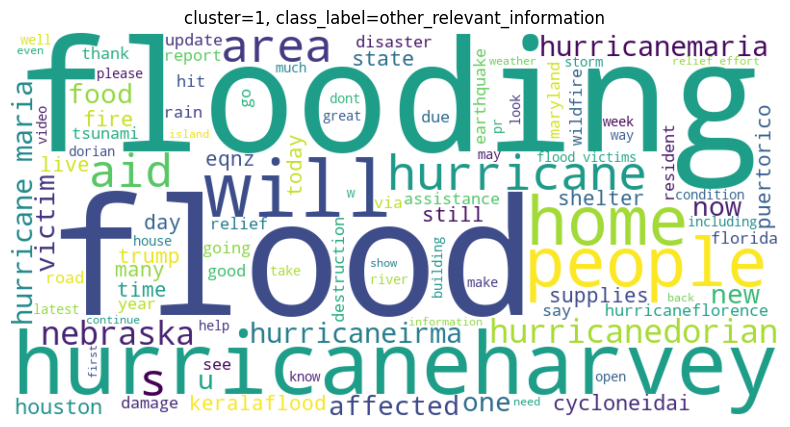

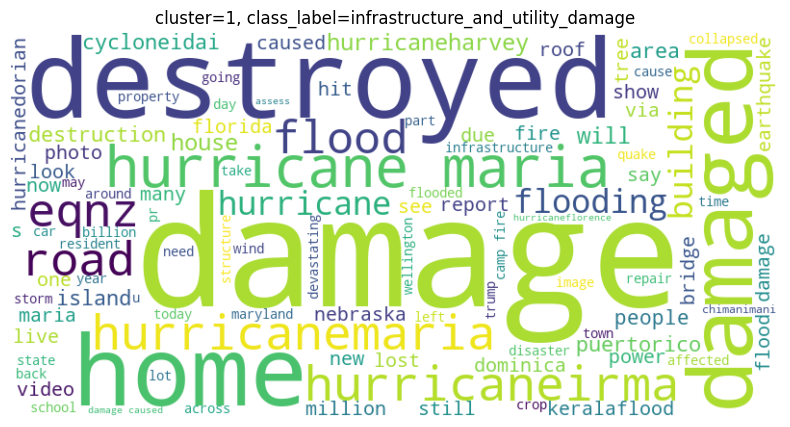

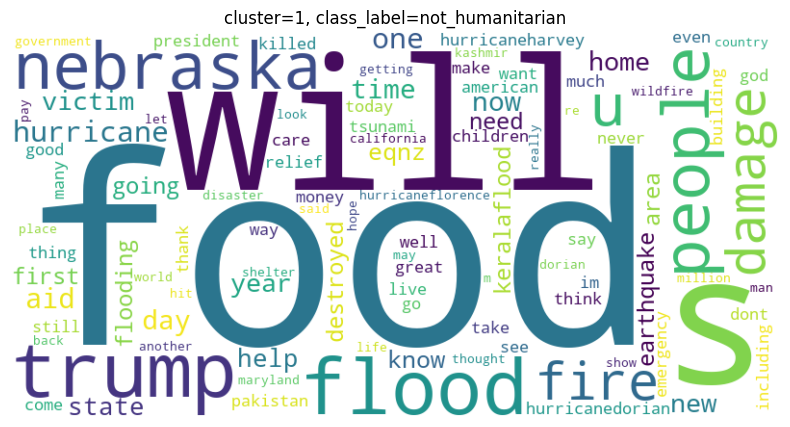

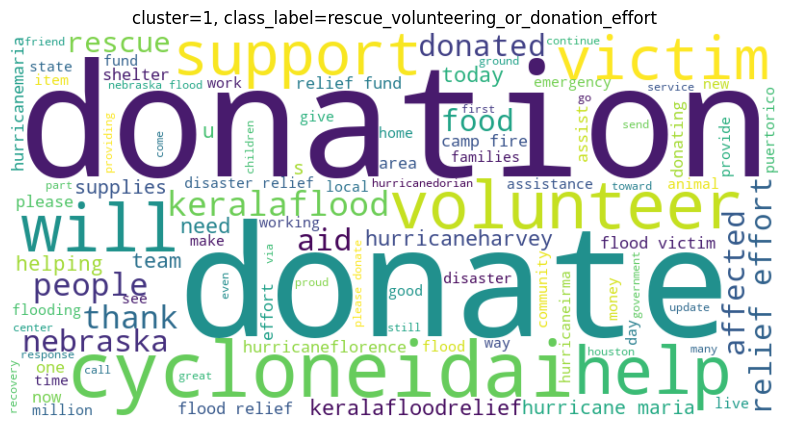

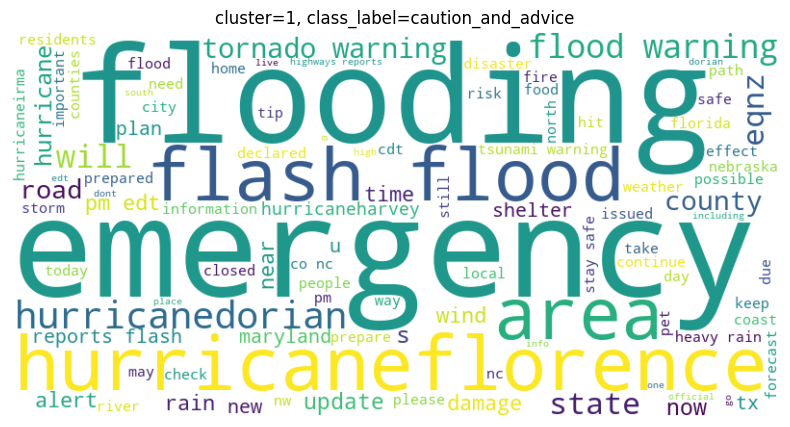

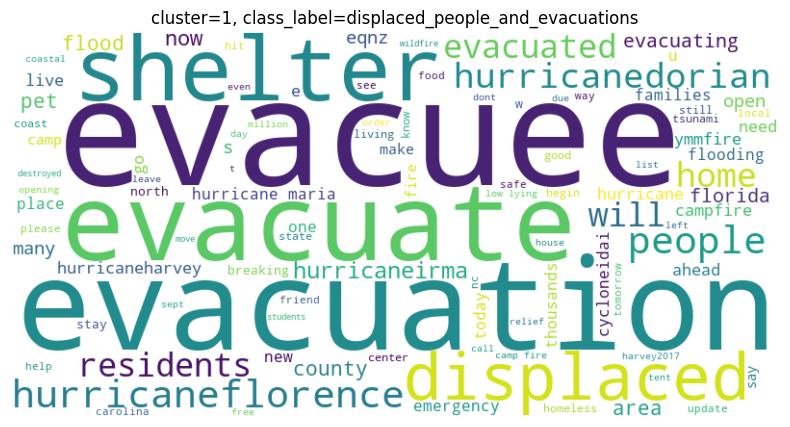

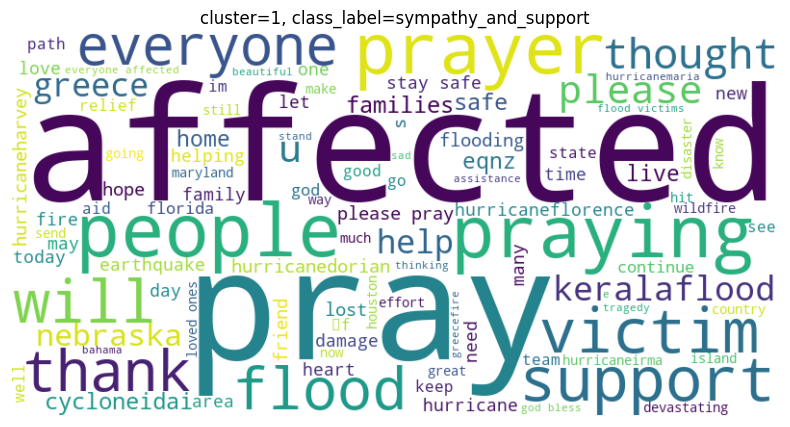

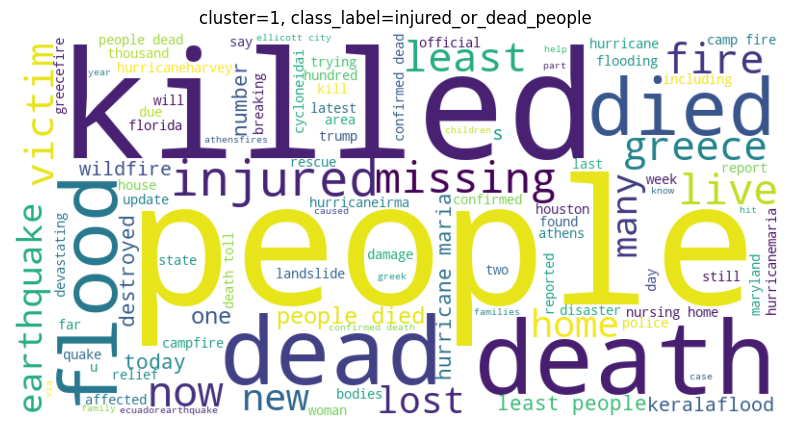

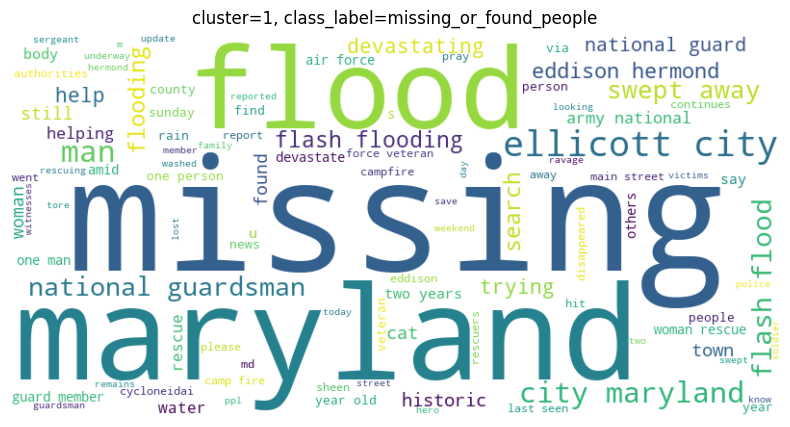

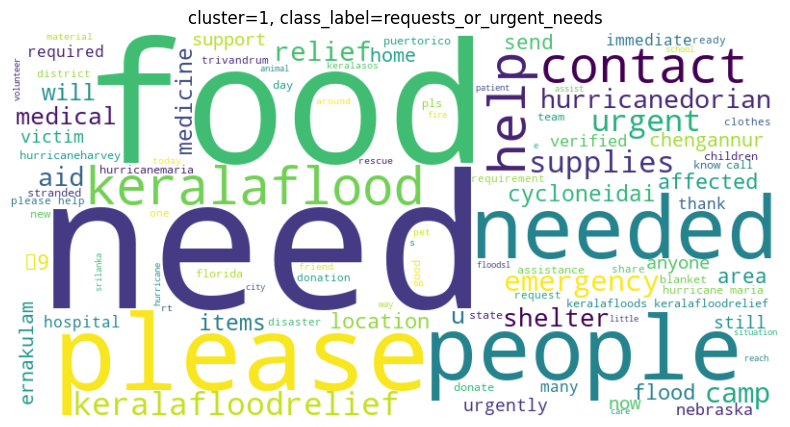

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def corpus_from_df(df, label_col, label_value, text_col='tweet_text'):
    subset = df[df[label_col] == label_value]
    # Une todos los textos en un solo string
    return " ".join(subset[text_col].astype(str))

def show_wordcloud(text, title=None):
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        max_words=100
    ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()
# Solo cluster 1

for cl in c1['class_label'].unique():
    text = corpus_from_df(c1, 'class_label', cl, text_col='tweet_text')
    show_wordcloud(text, title=f"cluster=1, class_label={cl}")


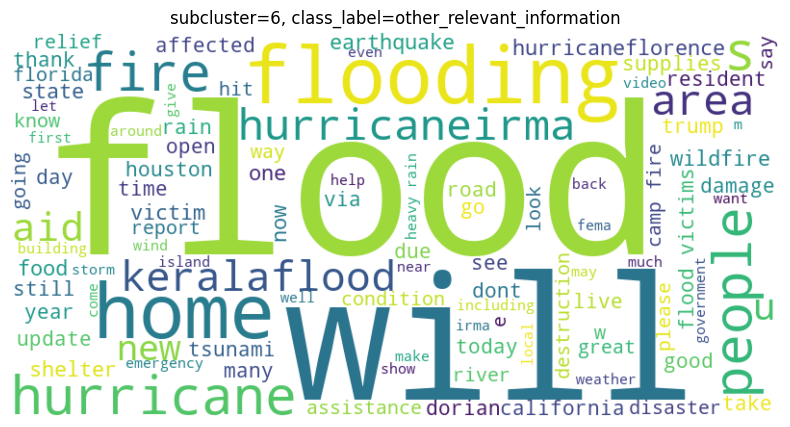

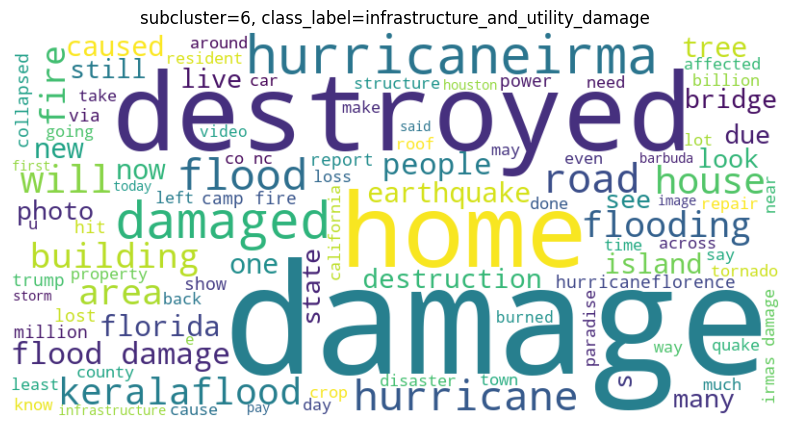

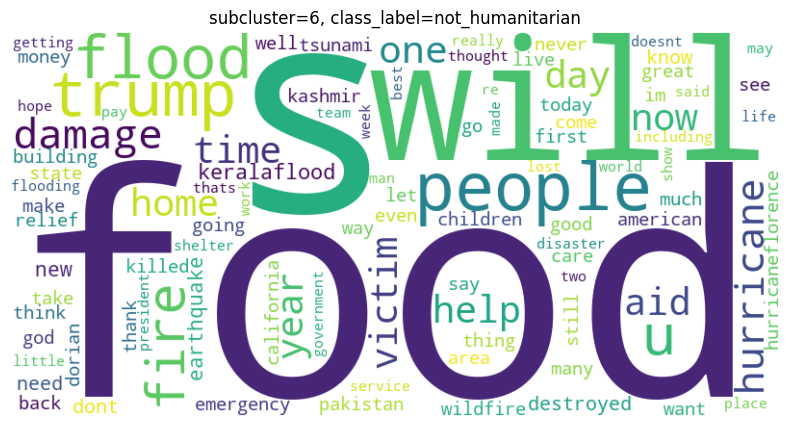

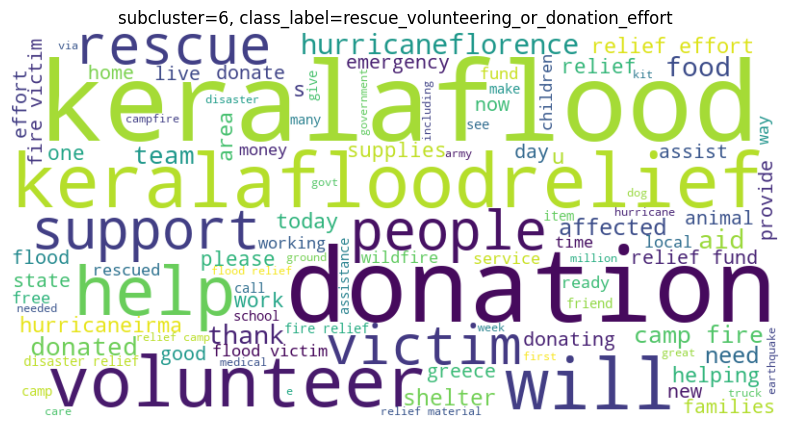

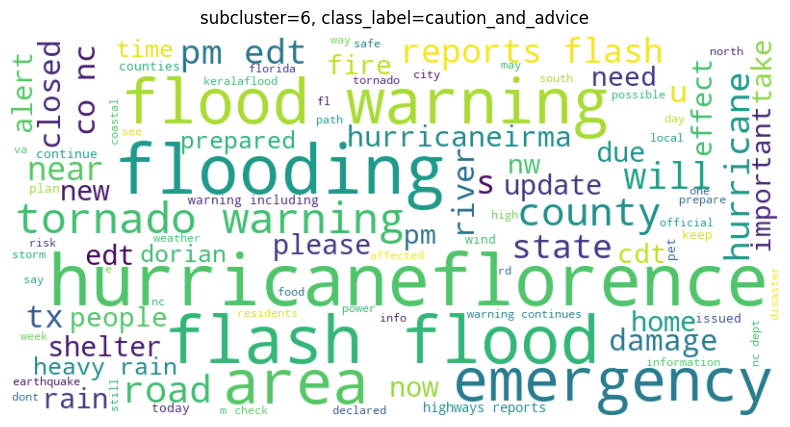

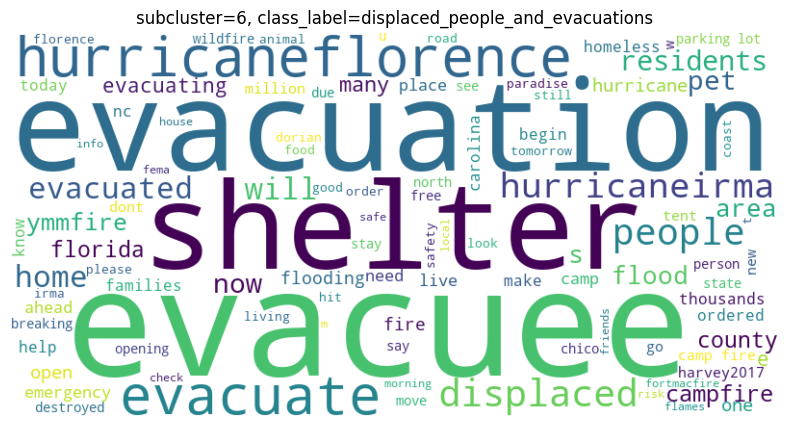

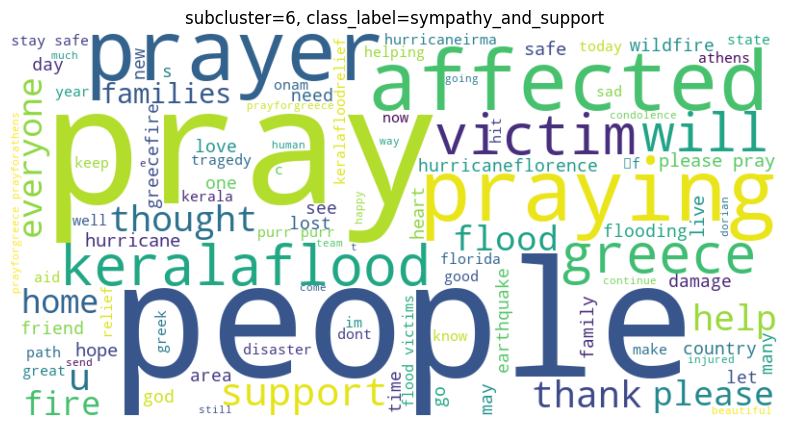

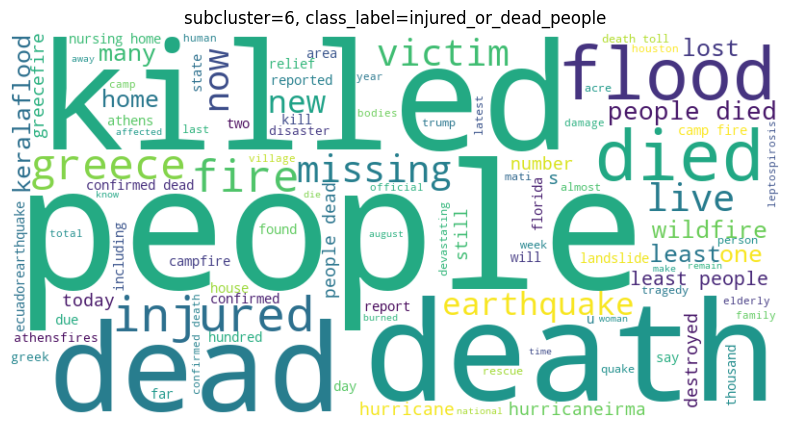

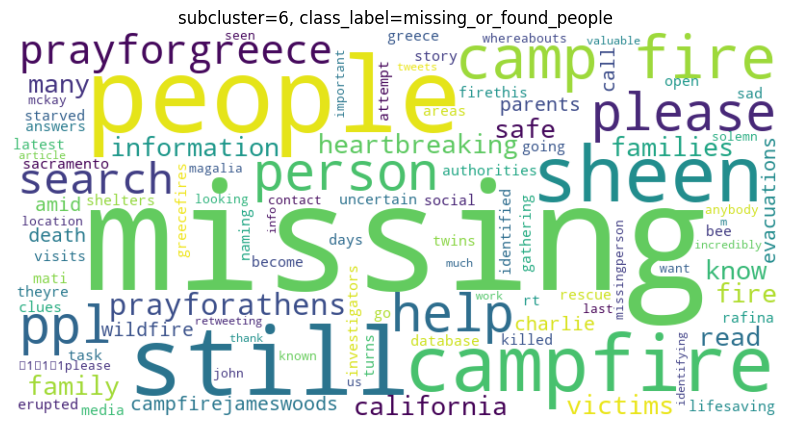

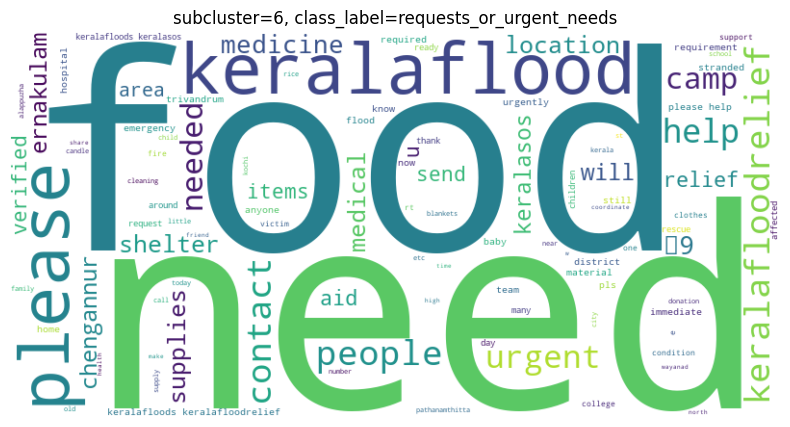

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Solo cluster 1
df_c6 = c1[c1['subcluster'] == 6]

for cl in df_c6['class_label'].unique():
    text = corpus_from_df(df_c6, 'class_label', cl, text_col='tweet_text')
    show_wordcloud(text, title=f"subcluster=6, class_label={cl}")


In [ ]:
print(c1.columns)


Index(['tweet_id', 'tweet_text', 'class_label', 'disaster_type', 'cluster',
       'subcluster'],
      dtype='object')
